# MLP model Regression

Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import fasttext
from sentence_transformers import SentenceTransformer

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

Load jokes' ratings

In [15]:
# Concatenate jokes' ratings from 3 source files
Y = pd.concat(pd.read_excel(f"data/jester_ratings_{i}.xls", header=None) for i in range(1, 4))

# Replace ratings of value 99 (representing no value in source data) with NaN
# Skip first column with jokes IDs
Y = Y.iloc[:, 1:].replace(99, float("NaN"))

# Print first 10 rows of data
print("First 10 rows of jokes' ratings data:")
print(Y.head(10))

# Print shape of the dataframe (number of rows and columns)
print("Number of rows and columns:")
print(Y.shape)

First 10 rows of jokes' ratings data:
    1     2     3     4     5     6     7     8     9     10   ...   91   \
0 -7.82  8.79 -9.66 -8.16 -7.52 -8.50 -9.85  4.17 -8.98 -4.76  ...  2.82   
1  4.08 -0.29  6.36  4.37 -2.38 -9.66 -0.73 -5.34  8.88  9.22  ...  2.82   
2   NaN   NaN   NaN   NaN  9.03  9.27  9.03  9.27   NaN   NaN  ...   NaN   
3   NaN  8.35   NaN   NaN  1.80  8.16 -2.82  6.21   NaN  1.84  ...   NaN   
4  8.50  4.61 -4.17 -5.39  1.36  1.60  7.04  4.61 -0.44  5.73  ...  5.19   
5 -6.17 -3.54  0.44 -8.50 -7.09 -4.32 -8.69 -0.87 -6.65 -1.80  ... -3.54   
6   NaN   NaN   NaN   NaN  8.59 -9.85  7.72  8.79   NaN   NaN  ...   NaN   
7  6.84  3.16  9.17 -6.21 -8.16 -1.70  9.27  1.41 -5.19 -4.42  ...  7.23   
8 -3.79 -3.54 -9.42 -6.89 -8.74 -0.29 -5.29 -8.93 -7.86 -1.60  ...  4.37   
9  3.01  5.15  5.15  3.01  6.41  5.15  8.93  2.52  3.01  8.16  ...   NaN   

    92    93    94    95    96    97    98    99    100  
0   NaN   NaN   NaN   NaN   NaN -5.63   NaN   NaN   NaN  
1 -4.95 -

Calculate mean rating for each joke

In [16]:
Y = Y.mean()

# Describe calculated data
print("Data description after mean calculation:")
print(Y.describe())

# Print first 10 rows of data
print("\nFirst 10 rows of jokes' ratings data:")
print(Y.head(10))

# Print shape of the dataframe (number of rows and columns)
print("\nNumber of rows and columns:")
print(Y.shape)

Data description after mean calculation:
count    100.000000
mean       0.702018
std        1.490444
min       -3.704541
25%       -0.416897
50%        0.996985
75%        1.793516
max        3.362593
dtype: float64

First 10 rows of jokes' ratings data:
1     0.901997
2     0.162989
3     0.193411
4    -1.412599
5     0.235352
6     1.330277
7    -0.633947
8    -0.996267
9    -0.620039
10    1.181706
dtype: float64

Number of rows and columns:
(100,)


Load joke texts

In [17]:
joke_texts = []
num_of_jokes = (Y.shape)[0]

for i in range(1, num_of_jokes + 1):
    with open(f"data/jokes/init{i}.html", "r") as file:
        soup = BeautifulSoup(file.read(), 'html.parser')
        extracted_joke_text = ' '.join(itertools.islice(soup.stripped_strings, 1, None))
        joke_text_no_long_whitespaces = ' '.join(extracted_joke_text.split())
        final_joke_text = joke_text_no_long_whitespaces.replace('Q.', '').replace('A.', '')
        joke_texts.append(final_joke_text.strip())
        
print("First 10 rows of joke texts:")
for num, joke in enumerate(joke_texts[:10]):
    print(f"{num}) {joke}")

First 10 rows of joke texts:
0) A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease". The man replies "Well,thank God I don't have cancer!"
1) This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. "What could they possibly have said to make you move out?" "They told me that you were a pedophile." He replied, "That's an awfully big word for a ten year old."
2) What's 200 feet long and has 4 teeth?  The front row at a Willie Nelson Concert.
3) What's the difference between a man and a toilet?  A toilet doesn't follow you around after you use it.
4) What's O. J. Simpson's Internet address?  Slash, slash, backslash, slash, slash, escape.
5) Bill & Hillary are on a trip back to Arkansas. They're almost out of gas, so Bill pulls into a service station on the outskirts of town. The 

Utils for creating charts and running MLP

In [18]:
import os

def create_chart(train_pred: list[float], test_pred: list[float], iterations: int, chart_filename: str, embeddings: str, parameter: str):
    _, ax = plt.subplots(figsize=(10,5))
    colors = ['#d62728', '#1f77b4']

    ax.plot(range(iterations), train_pred, label='Train set (X_train)', color=colors[0])
    ax.plot(range(iterations), test_pred, label='Test set (X_test)', color=colors[1])
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    ax.set_xticks(range( 0, iterations + 1, int(iterations/10) ))

    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE (loss function)')
    ax.set_title(f'MSE for train and test sets depending on the epoch with {embeddings} embeddings and parameter: {parameter}')
    ax.legend(loc='upper right')

    folder_path = 'charts'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.savefig(f'charts/{chart_filename}.png', dpi=300)
    plt.show()


def run_mlp_network(X_train, 
                    X_test, 
                    Y_train, 
                    Y_test, 
                    mlp_regressor: MLPRegressor, 
                    iterations: int, 
                    chart_filename: str, 
                    embeddings: str, 
                    parameter: str):
    train_set_predictions = []
    test_set_predictions = []

    for _ in range(iterations):
        mlp_regressor.fit(X_train, Y_train)

        # predict values for X_train set
        Y_train_pred = mlp_regressor.predict(X_train)
        train_set_predictions.append(mean_squared_error(Y_train, Y_train_pred))

        # predict values for X_test set
        Y_test_pred = mlp_regressor.predict(X_test)
        test_set_predictions.append(mean_squared_error(Y_test, Y_test_pred))
    
    create_chart(train_set_predictions, test_set_predictions, iterations, chart_filename, embeddings, parameter)

Supress warnings

In [19]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# MPL tests with Bert embeddings using various parameters

In [20]:
model = SentenceTransformer('bert-base-cased')
X = model.encode(joke_texts)

# Embeddings shape
print(X.shape)

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
d:\Dokumenty\Studia semestr VI\Sztuczna inteligencja\Lab\Lab5\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(100, 768)


Default MLP

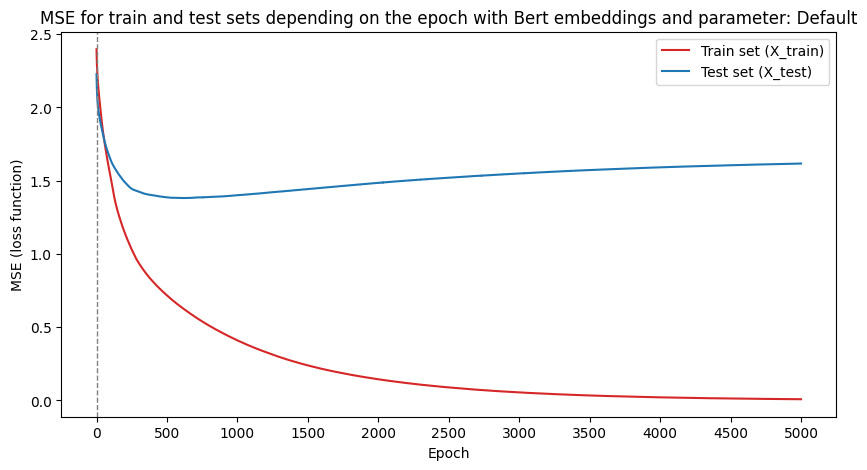

In [21]:
rng = np.random.RandomState(42)

mlp = MLPRegressor(solver='sgd', 
                   alpha=0.0, 
                   learning_rate='constant', 
                   random_state=rng, 
                   warm_start=True, 
                   max_iter=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
run_mlp_network(X_train, 
                X_test, 
                Y_train, 
                Y_test, 
                mlp, 
                iterations=5000, 
                chart_filename='bert_default', 
                embeddings='Bert', 
                parameter='Default')

MLP using various learning rate

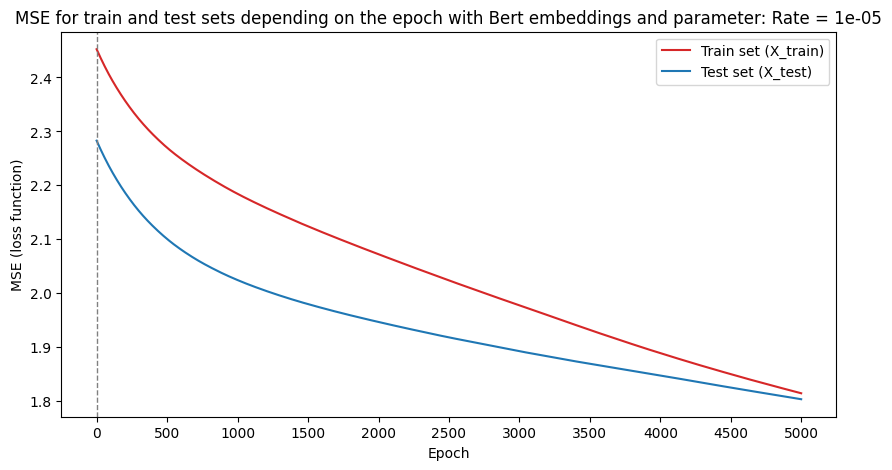

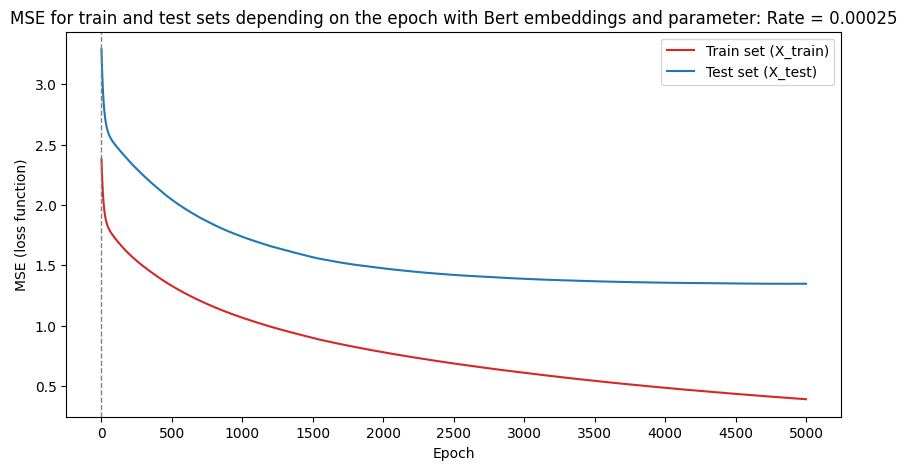

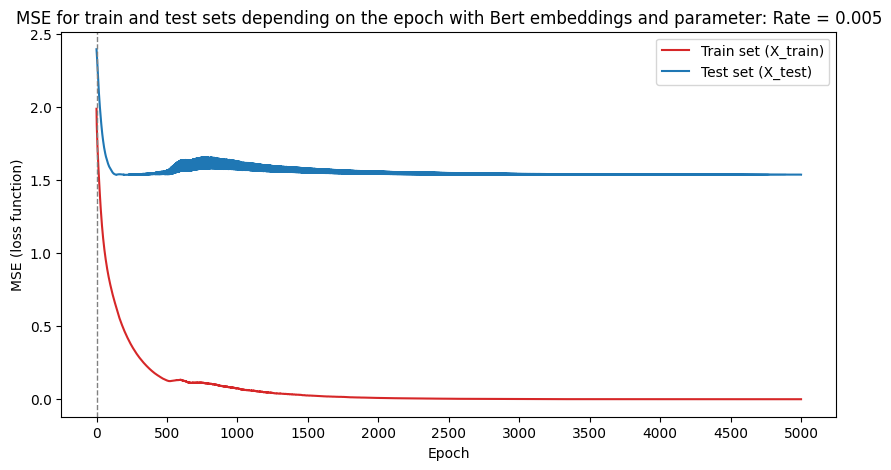

In [23]:
rng = np.random.RandomState(42)
learning_rates = [0.00001, 0.00025, 0.005]

for rate in learning_rates:
    mlp = MLPRegressor(solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant', 
                       learning_rate_init=rate, # setting learning rate
                       random_state=rng, 
                       warm_start=True, 
                       max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network(X_train, 
                    X_test, 
                    Y_train, 
                    Y_test, 
                    mlp, 
                    iterations=5000, 
                    chart_filename=f'bert_rate_{str(rate).replace('.', '_')}', 
                    embeddings='Bert', 
                    parameter=f'Rate = {rate}')

MLP using various neuron count

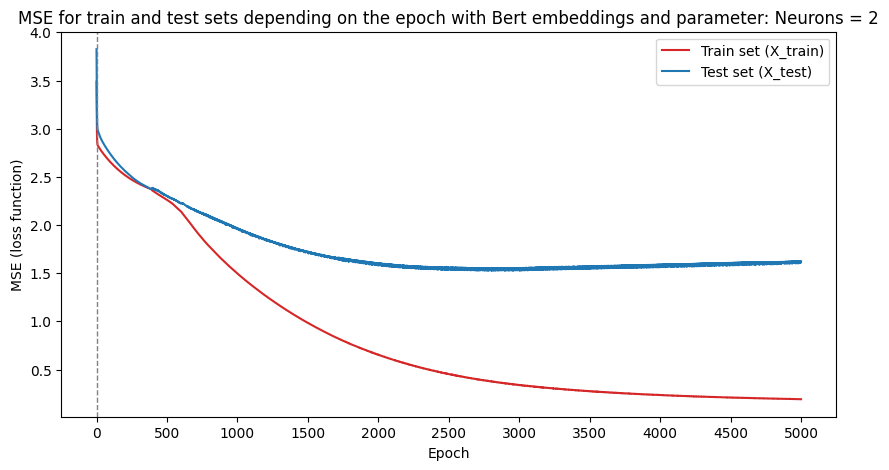

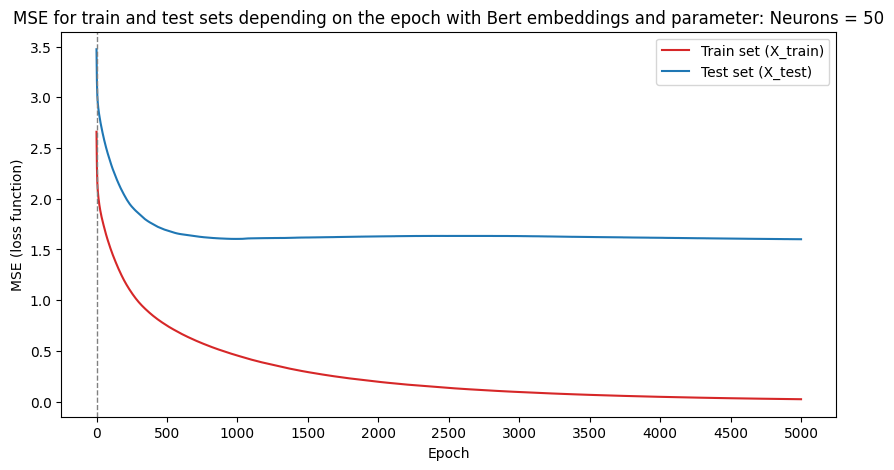

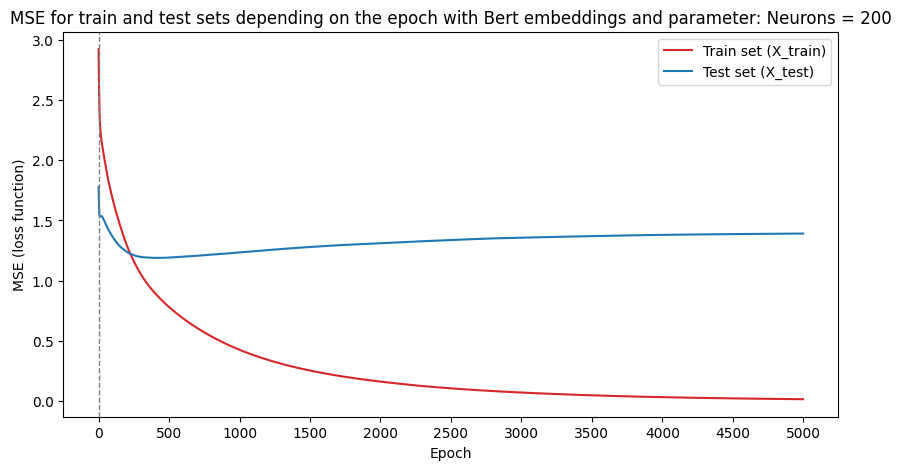

In [24]:
rng = np.random.RandomState(42)
neurons_counts = [2, 50, 200]

for count in neurons_counts:
    mlp = MLPRegressor(hidden_layer_sizes=(count,), # setting neuron count
                       solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant', 
                       random_state=rng, 
                       warm_start=True, 
                       max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network(X_train, 
                    X_test, 
                    Y_train, 
                    Y_test, 
                    mlp, 
                    iterations=5000, 
                    chart_filename=f'bert_neurons_{count}', 
                    embeddings='Bert', 
                    parameter=f'Neurons = {count}')